## 0. Imports libraries

In [1]:
import pandas as pd 
import numpy as np 
import seaborn as sns 
import matplotlib.pyplot as plt 
import json
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.feature_selection import f_classif, SelectKBest
from pickle import dump
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from sklearn.metrics import mean_absolute_error, r2_score
from sklearn.metrics import root_mean_squared_error
import warnings

def warn(*args, **kwargs):
    pass

warnings.warn = warn
warnings.filterwarnings("ignore", category=FutureWarning)

---

## 1. Problem statement and data collection

### 1.1 Description of the problem

``Business Insight``

Long-term deposits allow banks to hold money for a specific period of time, allowing the bank to use that money to enhance its investments. Marketing campaigns for this product are based on phone calls. If a user is not available at a given time, then they will be called back at another time.

``Description of the problem``

The Portuguese bank is experiencing a decline in revenue, so they want to be able to identify existing customers who are more likely to take out a long-term deposit. This will allow the bank to focus their marketing efforts on those customers and avoid wasting money and time on customers who are unlikely to sign up.

To address this problem we will create a ranking algorithm to help predict whether or not a customer will sign up for a long-term deposit.

### 1.2 Data collection

In [2]:
ruta = "https://raw.githubusercontent.com/4GeeksAcademy/logistic-regression-project-tutorial/main/bank-marketing-campaign-data.csv"

df_download = pd.read_csv(ruta, sep=";")
df_download.to_csv("/workspace/logistic_regression/data/raw/bank_marketing_data.csv", index=False)

df = pd.read_csv("/workspace/logistic_regression/data/raw/bank_marketing_data.csv")
df.head()

,age,job,marital,education,default,housing,loan,contact,month,day_of_week,...,campaign,pdays,previous,poutcome,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed,y
0,56,housemaid,married,basic.4y,no,no,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
1,57,services,married,high.school,unknown,no,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
2,37,services,married,high.school,no,yes,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
3,40,admin.,married,basic.6y,no,no,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
4,56,services,married,high.school,no,no,yes,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no


### 1.3 Understanding the features:

In [3]:
#Columnas
df.columns

Index(['age', 'job', 'marital', 'education', 'default', 'housing', 'loan',
       'contact', 'month', 'day_of_week', 'duration', 'campaign', 'pdays',
       'previous', 'poutcome', 'emp.var.rate', 'cons.price.idx',
       'cons.conf.idx', 'euribor3m', 'nr.employed', 'y'],
      dtype='object')

- **age** -> Age of customer -> (numeric)

- **job** -> Type of job -> (categorical)

- **marital** -> Marital status -> (categorical)

- **education** -> Level of education -> (categorical)

- **default** -> Do you currently have credit -> (categorical)

- **housing** -> Do you have a housing loan -> (categorical)

- **loan** -> Do you have a personal loan? -> (categorical)

- **contact** -> Type of contact communication -> (categorical)

- **month** -> Last month in which you have been contacted -> (categorical)

- **day_of_week** -> Last day on which you have been contacted -> (categorical)

- **duration** -> Duration of previous contact in seconds -> (numeric)

- **campaign** -> Number of contacts made during this campaign to the customer -> (numeric)

- **pdays** -> Number of days that elapsed since the last campaign until the customer was contacted -> (numeric)

- **previous** -> Number of contacts made during the previous campaign to the customer -> (numeric)

- **poutcome** -> Result of the previous marketing campaign -> (categorical)

- **emp.var.rate** -> Employment variation rate. Quarterly indicator -> (numeric)

- **cons.price.idx** -> Consumer price index. Monthly indicator -> (numeric)

- **cons.conf.idx** -> Consumer confidence index. Monthly indicator -> (numeric)

- **euribor3m** -> EURIBOR 3-month rate. Daily indicator -> (numeric)

- **nr.employed** -> Number of employees. Quarterly indicator -> (numeric)

- **y** -> ``TARGET`` -> Whether the customer takes out a long-term deposit or not -> (categorical)

### 1.3 Data exploration 

In [4]:
print(f'Our dataframe contains {len(df)} rows and it has {df.shape[1]} features.')

Our dataframe contains 41188 rows and it has 21 features.


In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 41188 entries, 0 to 41187
Data columns (total 21 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   age             41188 non-null  int64  
 1   job             41188 non-null  object 
 2   marital         41188 non-null  object 
 3   education       41188 non-null  object 
 4   default         41188 non-null  object 
 5   housing         41188 non-null  object 
 6   loan            41188 non-null  object 
 7   contact         41188 non-null  object 
 8   month           41188 non-null  object 
 9   day_of_week     41188 non-null  object 
 10  duration        41188 non-null  int64  
 11  campaign        41188 non-null  int64  
 12  pdays           41188 non-null  int64  
 13  previous        41188 non-null  int64  
 14  poutcome        41188 non-null  object 
 15  emp.var.rate    41188 non-null  float64
 16  cons.price.idx  41188 non-null  float64
 17  cons.conf.idx   41188 non-null 

In [6]:
df.describe()

,age,duration,campaign,pdays,previous,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed
count,41188.00000,41188.000000,41188.000000,41188.000000,41188.000000,41188.000000,41188.000000,41188.000000,41188.000000,41188.000000
mean,40.02406,258.285010,2.567593,962.475454,0.172963,0.081886,93.575664,-40.502600,3.621291,5167.035911
std,10.42125,259.279249,2.770014,186.910907,0.494901,1.570960,0.578840,4.628198,1.734447,72.251528
min,17.00000,0.000000,1.000000,0.000000,0.000000,-3.400000,92.201000,-50.800000,0.634000,4963.600000
25%,32.00000,102.000000,1.000000,999.000000,0.000000,-1.800000,93.075000,-42.700000,1.344000,5099.100000
50%,38.00000,180.000000,2.000000,999.000000,0.000000,1.100000,93.749000,-41.800000,4.857000,5191.000000
75%,47.00000,319.000000,3.000000,999.000000,0.000000,1.400000,93.994000,-36.400000,4.961000,5228.100000
max,98.00000,4918.000000,56.000000,999.000000,7.000000,1.400000,94.767000,-26.900000,5.045000,5228.100000


In [7]:
df.isna().sum()

age               0
job               0
marital           0
education         0
default           0
housing           0
loan              0
contact           0
month             0
day_of_week       0
duration          0
campaign          0
pdays             0
previous          0
poutcome          0
emp.var.rate      0
cons.price.idx    0
cons.conf.idx     0
euribor3m         0
nr.employed       0
y                 0
dtype: int64

In [8]:
df = df.drop_duplicates().reset_index(drop = True)

print(f'Our dataframe contains {len(df)} rows and it has {df.shape[1]} features.')

Our dataframe contains 41176 rows and it has 21 features.


**Conclusions:**

- We don't have any NaN in the dataframe
- We don't have any duplicated value
- The Data Frame contains categoricals (11) and numericals (10) features

### 1.4 Eliminating irrelevant information

In [9]:
df.head()

,age,job,marital,education,default,housing,loan,contact,month,day_of_week,...,campaign,pdays,previous,poutcome,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed,y
0,56,housemaid,married,basic.4y,no,no,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
1,57,services,married,high.school,unknown,no,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
2,37,services,married,high.school,no,yes,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
3,40,admin.,married,basic.6y,no,no,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
4,56,services,married,high.school,no,no,yes,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no


In [10]:
df

,age,job,marital,education,default,housing,loan,contact,month,day_of_week,...,campaign,pdays,previous,poutcome,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed,y
0,56,housemaid,married,basic.4y,no,no,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
1,57,services,married,high.school,unknown,no,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
2,37,services,married,high.school,no,yes,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
3,40,admin.,married,basic.6y,no,no,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
4,56,services,married,high.school,no,no,yes,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
41171,73,retired,married,professional.course,no,yes,no,cellular,nov,fri,...,1,999,0,nonexistent,-1.1,94.767,-50.8,1.028,4963.6,yes
41172,46,blue-collar,married,professional.course,no,no,no,cellular,nov,fri,...,1,999,0,nonexistent,-1.1,94.767,-50.8,1.028,4963.6,no
41173,56,retired,married,university.degree,no,yes,no,cellular,nov,fri,...,2,999,0,nonexistent,-1.1,94.767,-50.8,1.028,4963.6,no
41174,44,technician,married,professional.course,no,no,no,cellular,nov,fri,...,1,999,0,nonexistent,-1.1,94.767,-50.8,1.028,4963.6,yes


---

## 2. Univariated Analysis

### 2.1 Dividing our dataset into categorical adn numerical

In [11]:
# Understanding how many type of features we have
df.dtypes.unique()

array([dtype('int64'), dtype('O'), dtype('float64')], dtype=object)

In [12]:
# Dividing our dataframe by numerical and categorical features

num = ["int64", "float64"]
cat = ["O"]

df_num = df.select_dtypes(num)
df_cat = df.select_dtypes(cat)

In [13]:
#Numerical Data Frame
df_num.head(3)

,age,duration,campaign,pdays,previous,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed
0,56,261,1,999,0,1.1,93.994,-36.4,4.857,5191.0
1,57,149,1,999,0,1.1,93.994,-36.4,4.857,5191.0
2,37,226,1,999,0,1.1,93.994,-36.4,4.857,5191.0


In [14]:
#Categorical Dataframe
df_cat.head(3)

,job,marital,education,default,housing,loan,contact,month,day_of_week,poutcome,y
0,housemaid,married,basic.4y,no,no,no,telephone,may,mon,nonexistent,no
1,services,married,high.school,unknown,no,no,telephone,may,mon,nonexistent,no
2,services,married,high.school,no,yes,no,telephone,may,mon,nonexistent,no


### 2.2 Categorical Variable Analysis

In [15]:
df_cat.head(3)

,job,marital,education,default,housing,loan,contact,month,day_of_week,poutcome,y
0,housemaid,married,basic.4y,no,no,no,telephone,may,mon,nonexistent,no
1,services,married,high.school,unknown,no,no,telephone,may,mon,nonexistent,no
2,services,married,high.school,no,yes,no,telephone,may,mon,nonexistent,no


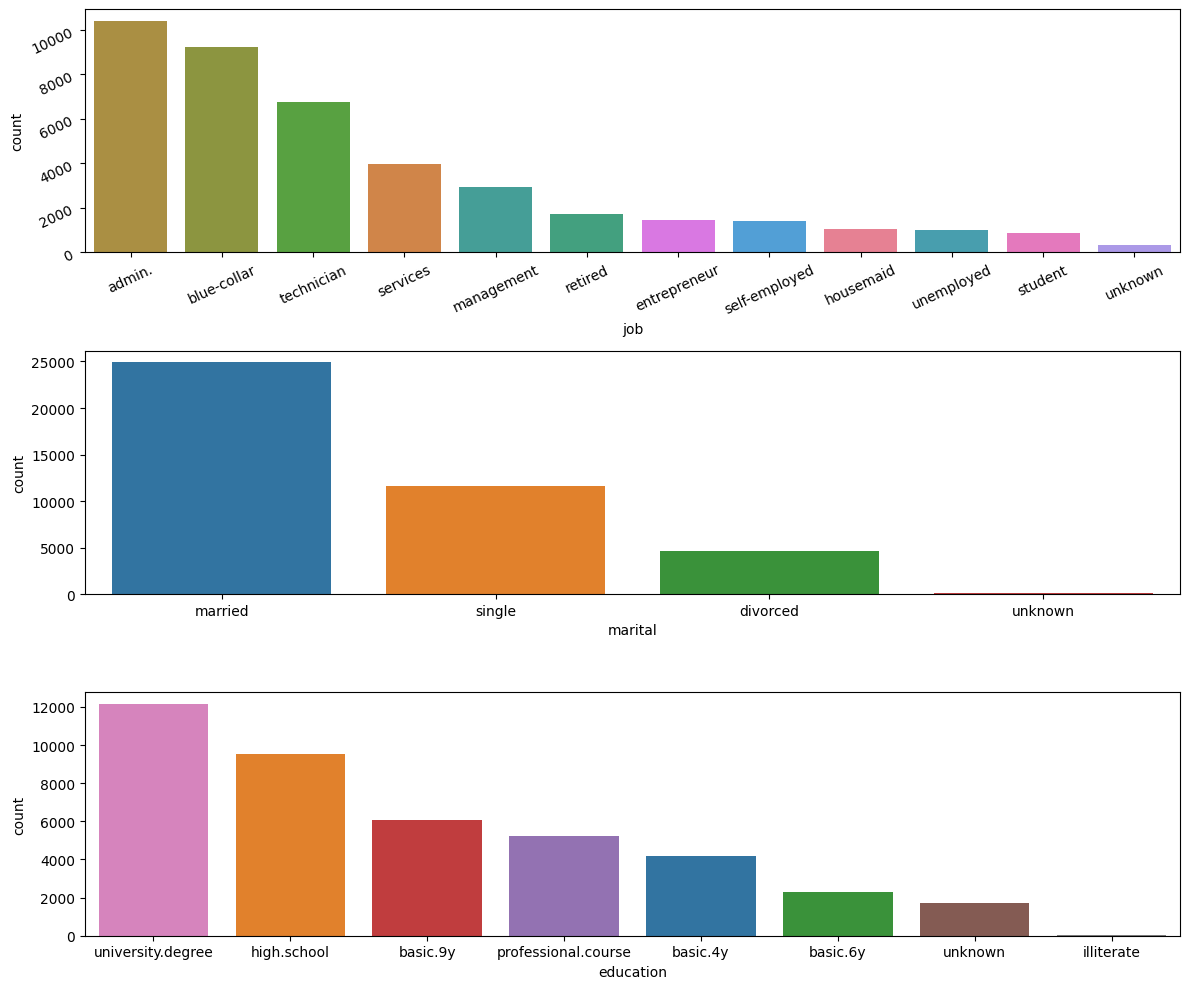

In [16]:
fig, ax = plt.subplots(nrows=3,ncols=1,figsize=(12,10))

sns.countplot(ax= ax[0], data=df_cat, x="job", order=df_cat["job"].value_counts().index, hue="job").tick_params(rotation=25)
sns.countplot(ax = ax[1], data=df_cat, x="marital", order=df_cat["marital"].value_counts().index, hue="marital")
sns.countplot(ax = ax[2], data=df_cat, x="education", order=df_cat["education"].value_counts().index, hue="education")

plt.tight_layout()
plt.show()

***Conclusions:***

**1. `job` (Occupation)**  
- The most common jobs are "admin.", "blue-collar", and "technician."  
- Less frequent jobs include "unknown," "student," and "illiterate," which might require grouping or special treatment.

**2. `marital` (Marital Status)**  
- Most clients are "married," followed by "single" and "divorced."  
- The "unknown" category is very small and may require handling.

**3. `education` (Education Level)**  
- "University degree" is the most common, followed by "high school."  
- Categories like "unknown" and "illiterate" are rare but might skew analysis if not addressed.


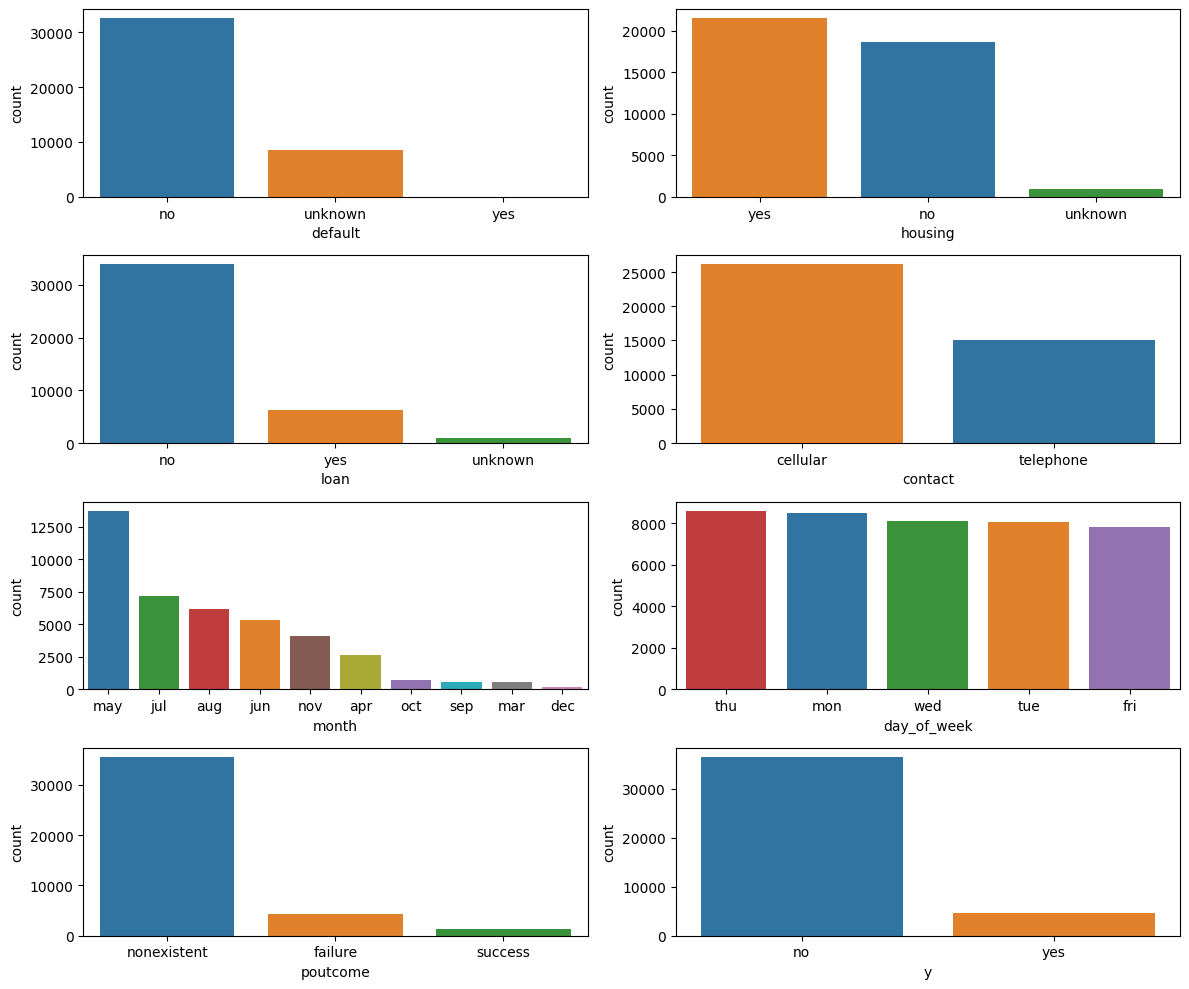

In [17]:
fig, ax = plt.subplots(4, 2, figsize= (12,10))

#Row #1
sns.countplot(ax= ax[0,0], data=df_cat, x="default", order=df_cat["default"].value_counts().index, hue="default")
sns.countplot(ax= ax[0,1], data=df_cat, x="housing", order=df_cat["housing"].value_counts().index, hue= "housing")
#Row #2
sns.countplot(ax= ax[1,0], data=df_cat, x="loan", order=df_cat["loan"].value_counts().index , hue= "loan")
sns.countplot(ax= ax[1,1], data=df_cat, x="contact", order=df_cat["contact"].value_counts().index , hue= "contact")
#Row #3
sns.countplot(ax= ax[2,0], data=df_cat, x="month", order=df_cat["month"].value_counts().index , hue= "month")
sns.countplot(ax= ax[2,1], data=df_cat, x="day_of_week", order=df_cat["day_of_week"].value_counts().index , hue= "day_of_week")
#Row #4
sns.countplot(ax= ax[3,0], data=df_cat, x="poutcome", order=df_cat["poutcome"].value_counts().index , hue= "poutcome")
sns.countplot(ax= ax[3,1], data=df_cat, x="y", order=df_cat["y"].value_counts().index , hue= "y")

plt.tight_layout()
plt.show()

***Conclusions:***

**1. `default` (Credit Default)**  
- Most clients have "no" credit default.  

**2. `loan` (Personal Loan)**  
- The majority do not have a personal loan.  

**3. `housing` (Housing Loan)**  
- Similar distribution between "yes" and "no."  

**4. `contact` (Contact Method)**  
- Most contacts were made via "cellular," while fewer were made via "telephone."

**5. `month` (Last Contact Month)**  
- "May" dominates as the month with the most contacts.  

**6. `day_of_week` (Last Contact Day of the Week)**  
- Uniform distribution across the weekdays.  
- No significant day stands out.

**7. `poutcome` (Outcome of Previous Campaign)**  
- Most clients fall into "nonexistent," indicating no prior contact.  
- Few were categorized as "failure" or "success."

**8. `y` (Response to Campaign)**  
- Highly imbalanced, with "no" dominating the responses.  
- The "yes" category represents a small portion of the dataset.


### 2.3 Numerical Variable Analysis

In [18]:
df_num.head(3)

,age,duration,campaign,pdays,previous,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed
0,56,261,1,999,0,1.1,93.994,-36.4,4.857,5191.0
1,57,149,1,999,0,1.1,93.994,-36.4,4.857,5191.0
2,37,226,1,999,0,1.1,93.994,-36.4,4.857,5191.0


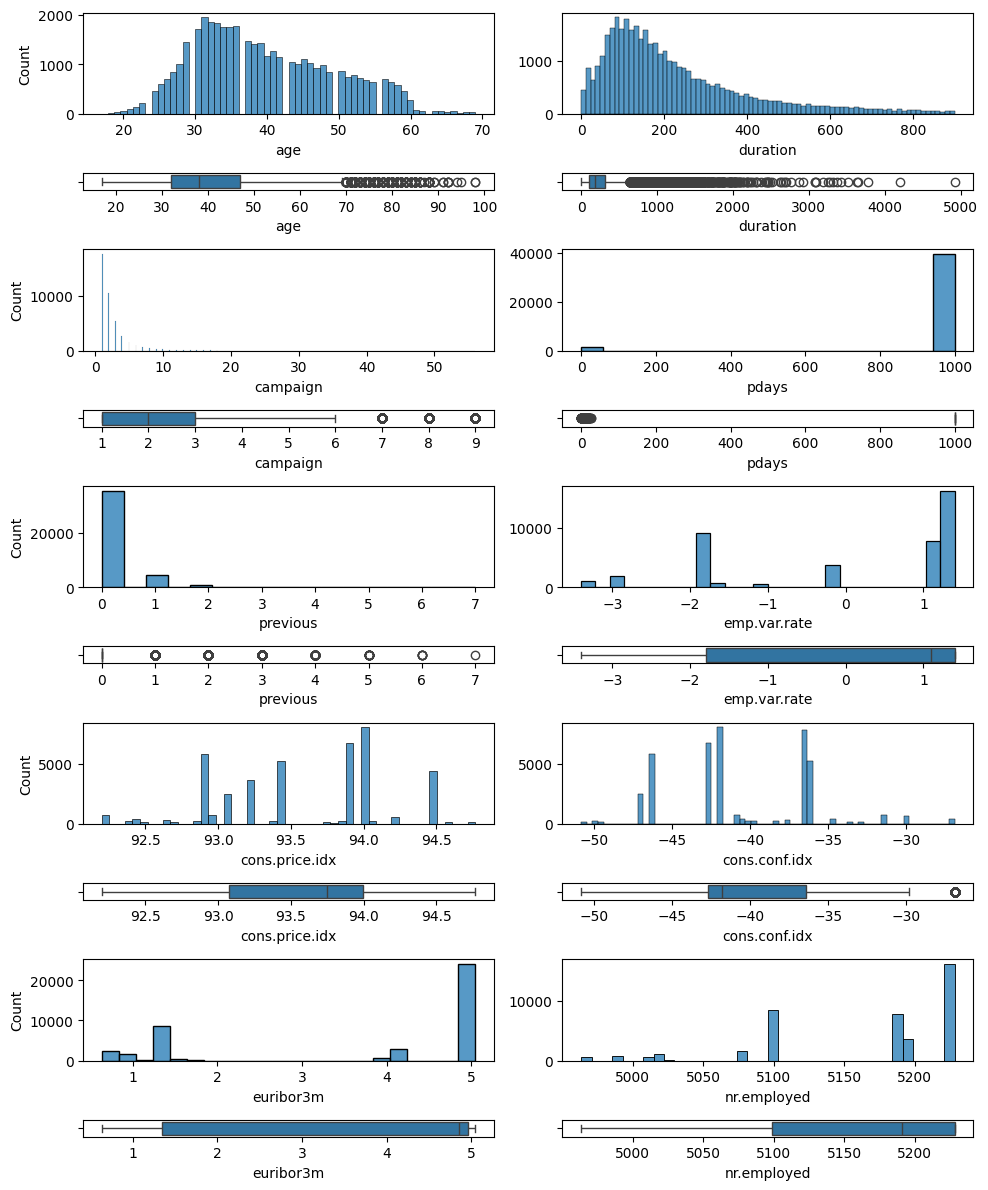

In [19]:
fig, ax = plt.subplots(10, 2, figsize=(10,12), gridspec_kw={"height_ratios":[6,1,6,1,6,1,6,1,6,1]})

#Row_1
sns.histplot(ax = ax[0,0], data=df_num[df_num["age"] < 70], x="age")
sns.boxplot(ax = ax[1,0], data=df_num, x="age")
sns.histplot(ax = ax[0,1], data=df_num[df_num["duration"] < 900], x="duration").set(ylabel=None)
sns.boxplot(ax = ax[1,1], data=df_num, x="duration")

#Row_2
sns.histplot(ax = ax[2,0], data=df_num, x="campaign")
sns.boxplot(ax = ax[3,0], data=df_num[df_num["campaign"] < 10], x="campaign")
sns.histplot(ax = ax[2,1], data=df_num, x="pdays").set(ylabel=None)
sns.boxplot(ax = ax[3,1], data=df_num, x="pdays")

#Row_3
sns.histplot(ax = ax[4,0], data=df_num, x="previous")
sns.boxplot(ax = ax[5,0], data=df_num, x="previous")
sns.histplot(ax = ax[4,1], data=df_num, x="emp.var.rate").set(ylabel=None)
sns.boxplot(ax = ax[5,1], data=df_num, x="emp.var.rate")

#Row_4
sns.histplot(ax = ax[6,0], data=df_num, x="cons.price.idx")
sns.boxplot(ax = ax[7,0], data=df_num, x="cons.price.idx")
sns.histplot(ax = ax[6,1], data=df_num, x="cons.conf.idx").set(ylabel=None)
sns.boxplot(ax = ax[7,1], data=df_num, x="cons.conf.idx")

#Row_5
sns.histplot(ax = ax[8,0], data=df_num, x="euribor3m")
sns.boxplot(ax = ax[9,0], data=df_num, x="euribor3m")
sns.histplot(ax = ax[8,1], data=df_num, x="nr.employed").set(ylabel=None)
sns.boxplot(ax = ax[9,1], data=df_num, x="nr.employed")

plt.tight_layout()
fig.subplots_adjust(hspace=1)
plt.show()

***Conclusions:***

**1. `age` (Age)**  
- Unimodal distribution with a peak around 30-40 years old.  
- Outliers detected near 90 years, which may require review.

**2. `duration` (Duration)**  
- Positively skewed distribution with most calls being short.  
- Some extreme outliers with long call durations.

**3. `campaign` (Number of Contacts in Current Campaign)**  
- Most customers were contacted 1-2 times, with a sharp drop for higher values.  
- Outliers with over 40 contacts may need investigation.

**4. `pdays` (Days Since Last Contact)**  
- Dominated by the value 999, likely representing "not contacted before."  
- Challenging to analyze due to the overwhelming majority of this value.

**5. `previous` (Number of Contacts in Previous Campaigns)**  
- Most customers were contacted 1-2 times or not at all.  
- Rare cases with more than 3-4 contacts.

**6. `emp.var.rate` (Employment Variation Rate)**  
- Discrete peaks in the distribution, indicating grouped or categorical intervals.  
- No evident outliers.

**7. `cons.price.idx` (Consumer Price Index)**  
- Several peaks, likely representing specific intervals.  
- No outliers observed.

**8. `cons.conf.idx` (Consumer Confidence Index)**  
- Grouped into specific values with no extreme outliers.  
- Appears evenly distributed across the range.

**9. `euribor3m` (3-Month Euribor Rate)**  
- Highly concentrated in a few dominant values, likely due to measurement intervals.  
- No significant outliers.

**10. `nr.employed` (Number of Employees)**  
- Strongly concentrated around specific values.  
- No anomalies or outliers.

### 2.4 Multivariate Analysis

#### 2.4.1 Analysis Categorical - Categorical

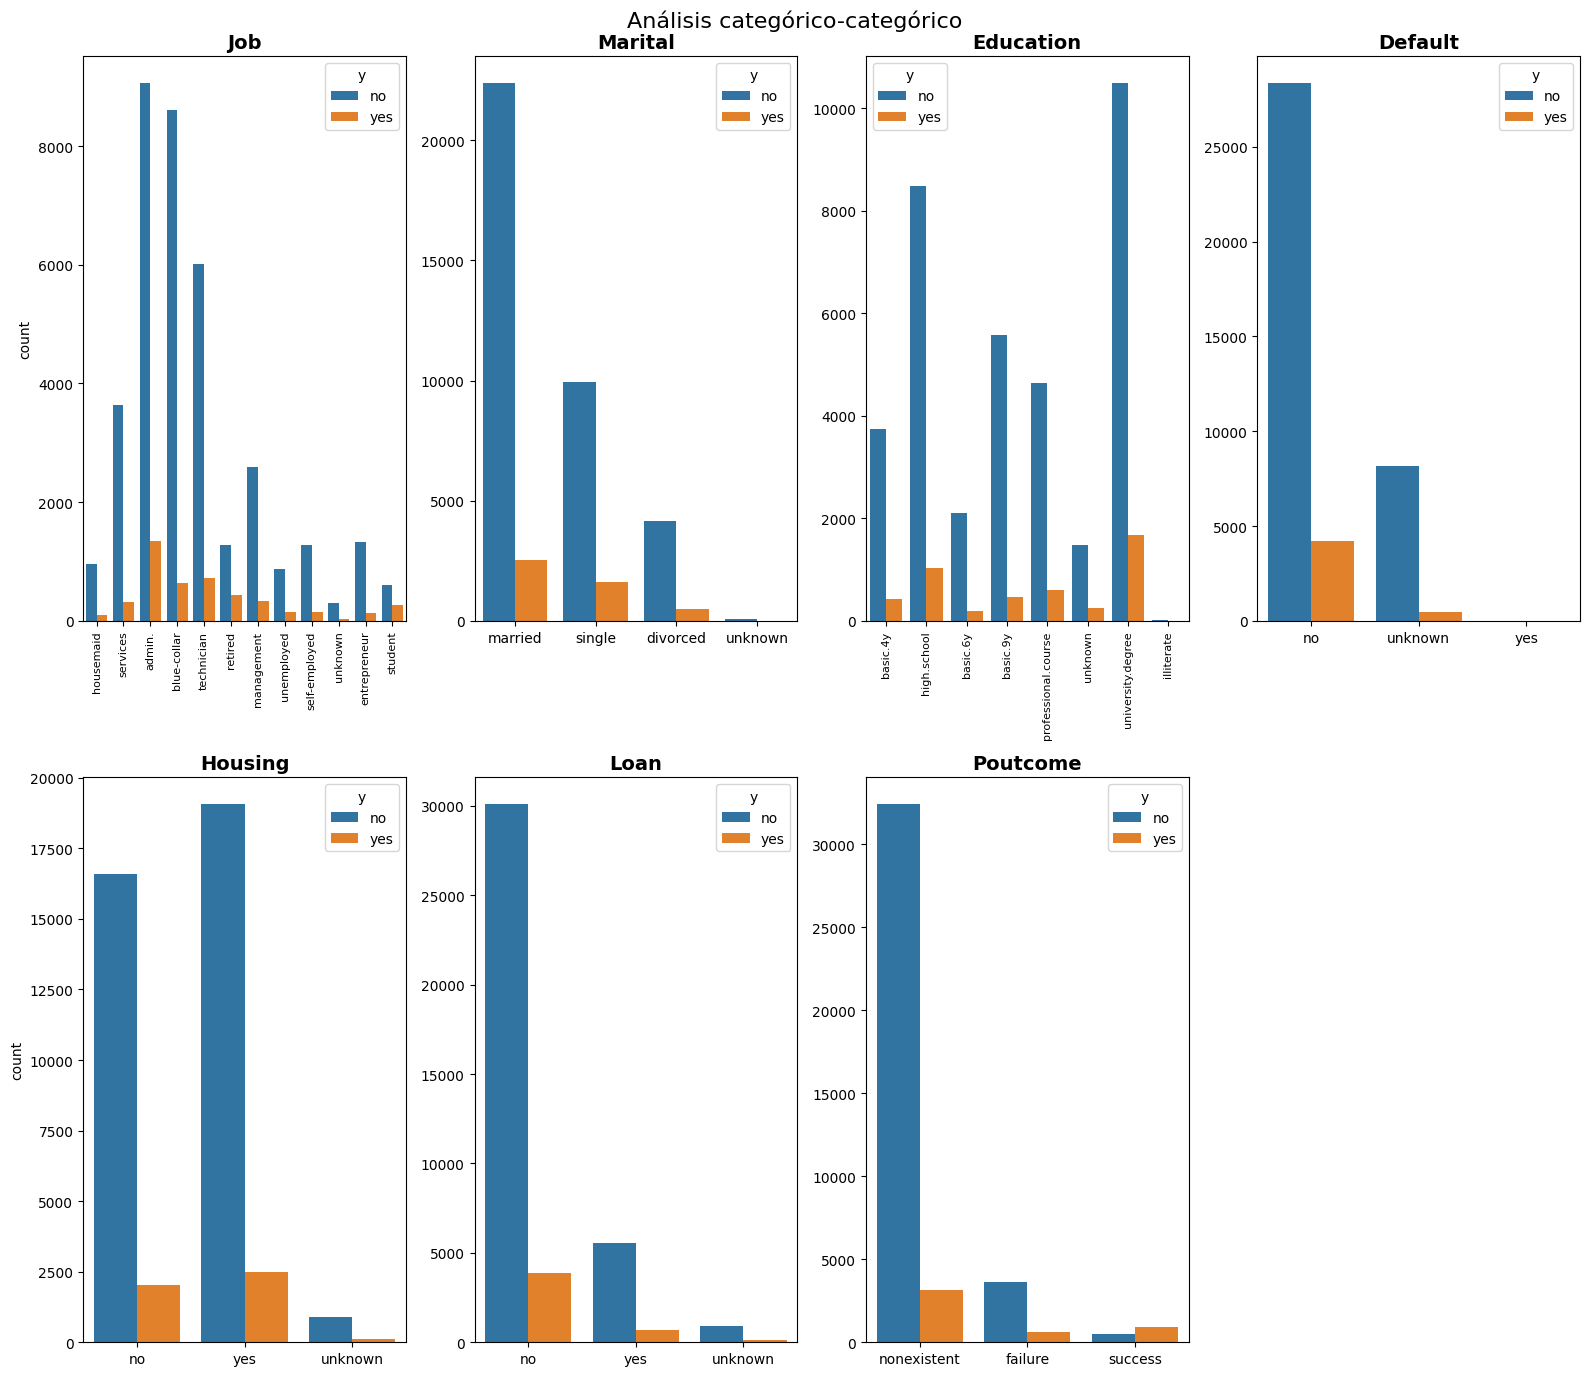

In [20]:

fig, axis = plt.subplots(2, 4, figsize = (16, 14))
fig.suptitle("Análisis categórico-categórico", fontsize=16)

sns.countplot(ax = axis[0, 0], data = df_cat, x="job", hue = "y").set(xlabel= None)
axis[0, 0].set_xticklabels(axis[0, 0].get_xticklabels(), rotation=90, fontsize=8)
sns.countplot(ax = axis[0, 1], data = df_cat, x="marital", hue = "y").set(xlabel= None, ylabel = None)
sns.countplot(ax = axis[0, 2], data = df_cat, x="education", hue = "y").set(xlabel= None, ylabel = None)
axis[0, 2].set_xticklabels(axis[0, 2].get_xticklabels(), rotation=90, fontsize=8)
sns.countplot(ax = axis[0, 3], data = df_cat, x="default", hue = "y").set(xlabel= None, ylabel = None)
sns.countplot(ax = axis[1, 0], data = df_cat, x="housing", hue = "y").set(xlabel= None)
sns.countplot(ax = axis[1, 1], data = df_cat, x="loan", hue = "y").set(xlabel= None, ylabel = None)
sns.countplot(ax = axis[1, 2], data = df_cat, x="poutcome", hue = "y").set(xlabel= None, ylabel = None)

axis[0, 0].set_title("Job", fontsize=14, fontweight='bold')
axis[0, 1].set_title("Marital", fontsize=14, fontweight='bold')
axis[0, 2].set_title("Education", fontsize=14, fontweight='bold')
axis[0, 3].set_title("Default", fontsize=14, fontweight='bold')
axis[1, 0].set_title("Housing", fontsize=14, fontweight='bold')
axis[1, 1].set_title("Loan", fontsize=14, fontweight='bold')
axis[1, 2].set_title("Poutcome", fontsize=14, fontweight='bold')

fig.delaxes(axis[1, 3])

plt.tight_layout()
plt.show()

#### 2.4.2 Encoding Categorical Values and Saving JSON files

In [21]:
df_enc = df.copy()

In [22]:
# Creating encoders for categorical features and saving them as JSON files. All files prefixed with 'enc'
# contain the encoding dictionaries for each categorical feature.
for column in df_cat.columns:
    unique_values = list(df_cat[column].unique())
    globals()[f"{column}_enc"] = dict(zip(unique_values, range(len(unique_values))))

    json.dump(globals()[f"{column}_enc"], open(f'../data/interim/enc_{column}.json', 'w'))

In [23]:
# Replacing the values in our categorical features to our encoded values (numerical)
for column in df_cat.columns:
    df_enc[column] = df_enc[column].map(json.load(open(f'../data/interim/enc_{column}.json')))

In [24]:
df_enc.head()

,age,job,marital,education,default,housing,loan,contact,month,day_of_week,...,campaign,pdays,previous,poutcome,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed,y
0,56,0,0,0,0,0,0,0,0,0,...,1,999,0,0,1.1,93.994,-36.4,4.857,5191.0,0
1,57,1,0,1,1,0,0,0,0,0,...,1,999,0,0,1.1,93.994,-36.4,4.857,5191.0,0
2,37,1,0,1,0,1,0,0,0,0,...,1,999,0,0,1.1,93.994,-36.4,4.857,5191.0,0
3,40,2,0,2,0,0,0,0,0,0,...,1,999,0,0,1.1,93.994,-36.4,4.857,5191.0,0
4,56,1,0,1,0,0,1,0,0,0,...,1,999,0,0,1.1,93.994,-36.4,4.857,5191.0,0


### 2.4.3 Analysis Numerical - Numerical

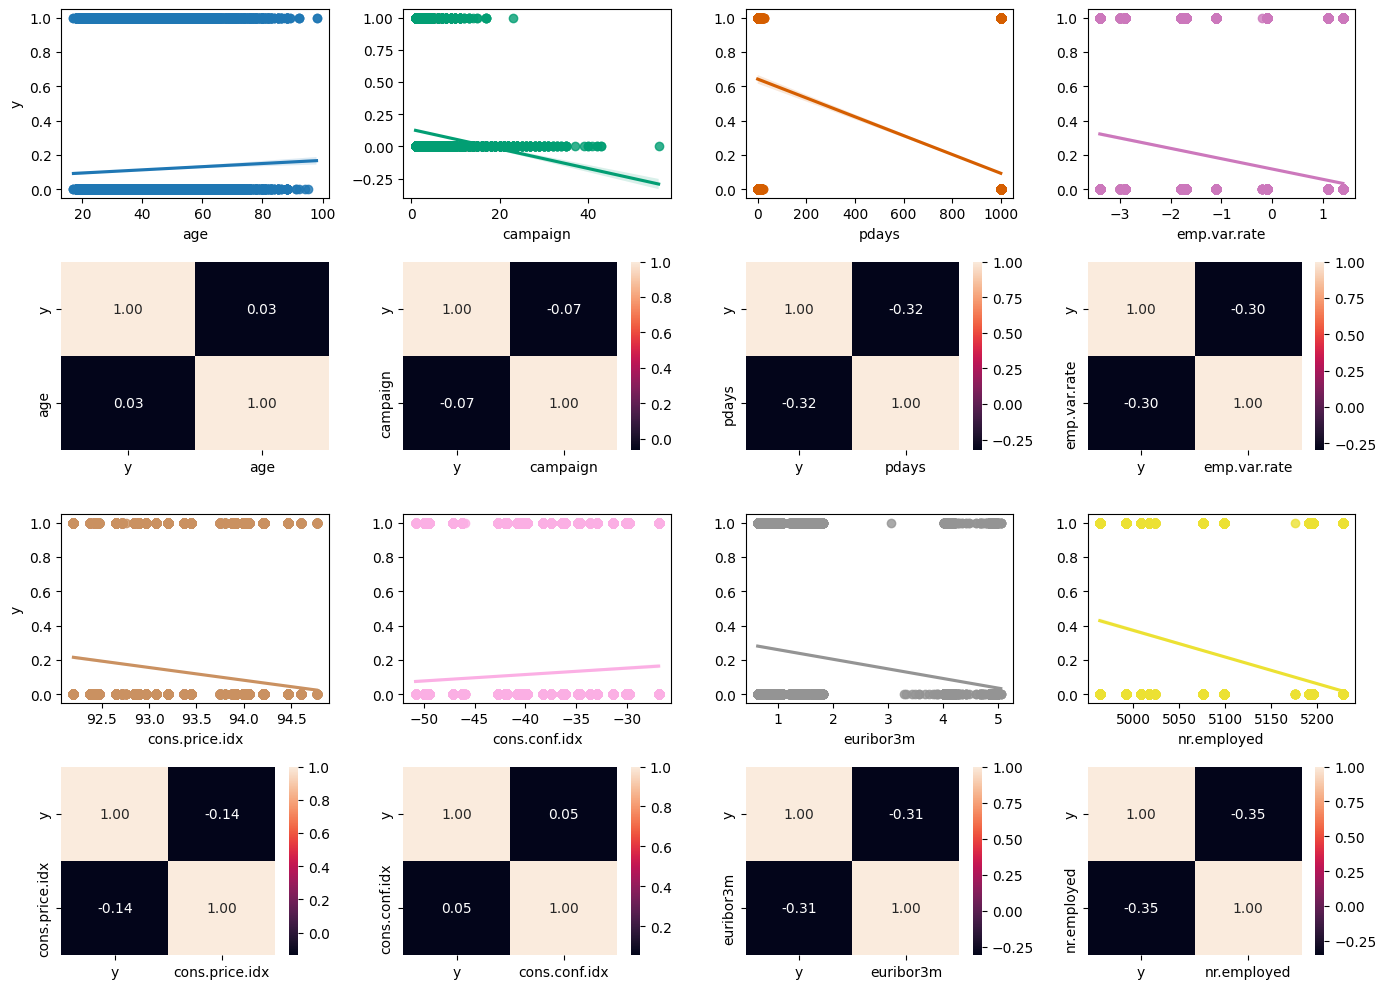

In [25]:
fig, axis = plt.subplots(4, 4, figsize = (14, 10))

sns.regplot(ax = axis[0, 0], data = df_enc, x = "age", y = "y")
sns.heatmap(df_enc[["y", "age"]].corr(), annot = True, fmt = ".2f", ax = axis[1, 0], cbar = False)

sns.regplot(ax = axis[0, 1], data = df_enc, x = "campaign", y = "y", color=sns.color_palette("colorblind")[2]).set(ylabel = None)
sns.heatmap(df_enc[["y", "campaign"]].corr(), annot = True, fmt = ".2f", ax = axis[1, 1])

sns.regplot(ax = axis[0, 2], data = df_enc, x = "pdays", y = "y", color=sns.color_palette("colorblind")[3]).set(ylabel = None)
sns.heatmap(df_enc[["y", "pdays"]].corr(), annot = True, fmt = ".2f", ax = axis[1, 2]).set(ylabel = None)

sns.regplot(ax = axis[0, 3], data = df_enc, x = "emp.var.rate", y = "y", color=sns.color_palette("colorblind")[4]).set(ylabel = None)
sns.heatmap(df_enc[["y", "emp.var.rate"]].corr(), annot = True, fmt = ".2f", ax = axis[1, 3]).set(ylabel = None)

sns.regplot(ax = axis[2, 0], data = df_enc, x = "cons.price.idx", y = "y", color=sns.color_palette("colorblind")[5])
sns.heatmap(df_enc[["y", "cons.price.idx"]].corr(), annot = True, fmt = ".2f", ax = axis[3, 0])

sns.regplot(ax = axis[2, 1], data = df_enc, x = "cons.conf.idx", y = "y", color=sns.color_palette("colorblind")[6]).set(ylabel = None)
sns.heatmap(df_enc[["y", "cons.conf.idx"]].corr(), annot = True, fmt = ".2f", ax = axis[3, 1]).set(ylabel = None)

sns.regplot(ax = axis[2, 2], data = df_enc, x = "euribor3m", y = "y", color=sns.color_palette("colorblind")[7]).set(ylabel = None)
sns.heatmap(df_enc[["y", "euribor3m"]].corr(), annot = True, fmt = ".2f", ax = axis[3, 2]).set(ylabel = None)

sns.regplot(ax = axis[2, 3], data = df_enc, x = "nr.employed", y = "y", color=sns.color_palette("colorblind")[8]).set(ylabel = None)
sns.heatmap(df_enc[["y", "nr.employed"]].corr(), annot = True, fmt = ".2f", ax = axis[3, 3]).set(ylabel = None)

plt.tight_layout()
plt.show()

#### 2.4.4 Numerical - Categorical analysis (Correlational Analysis)

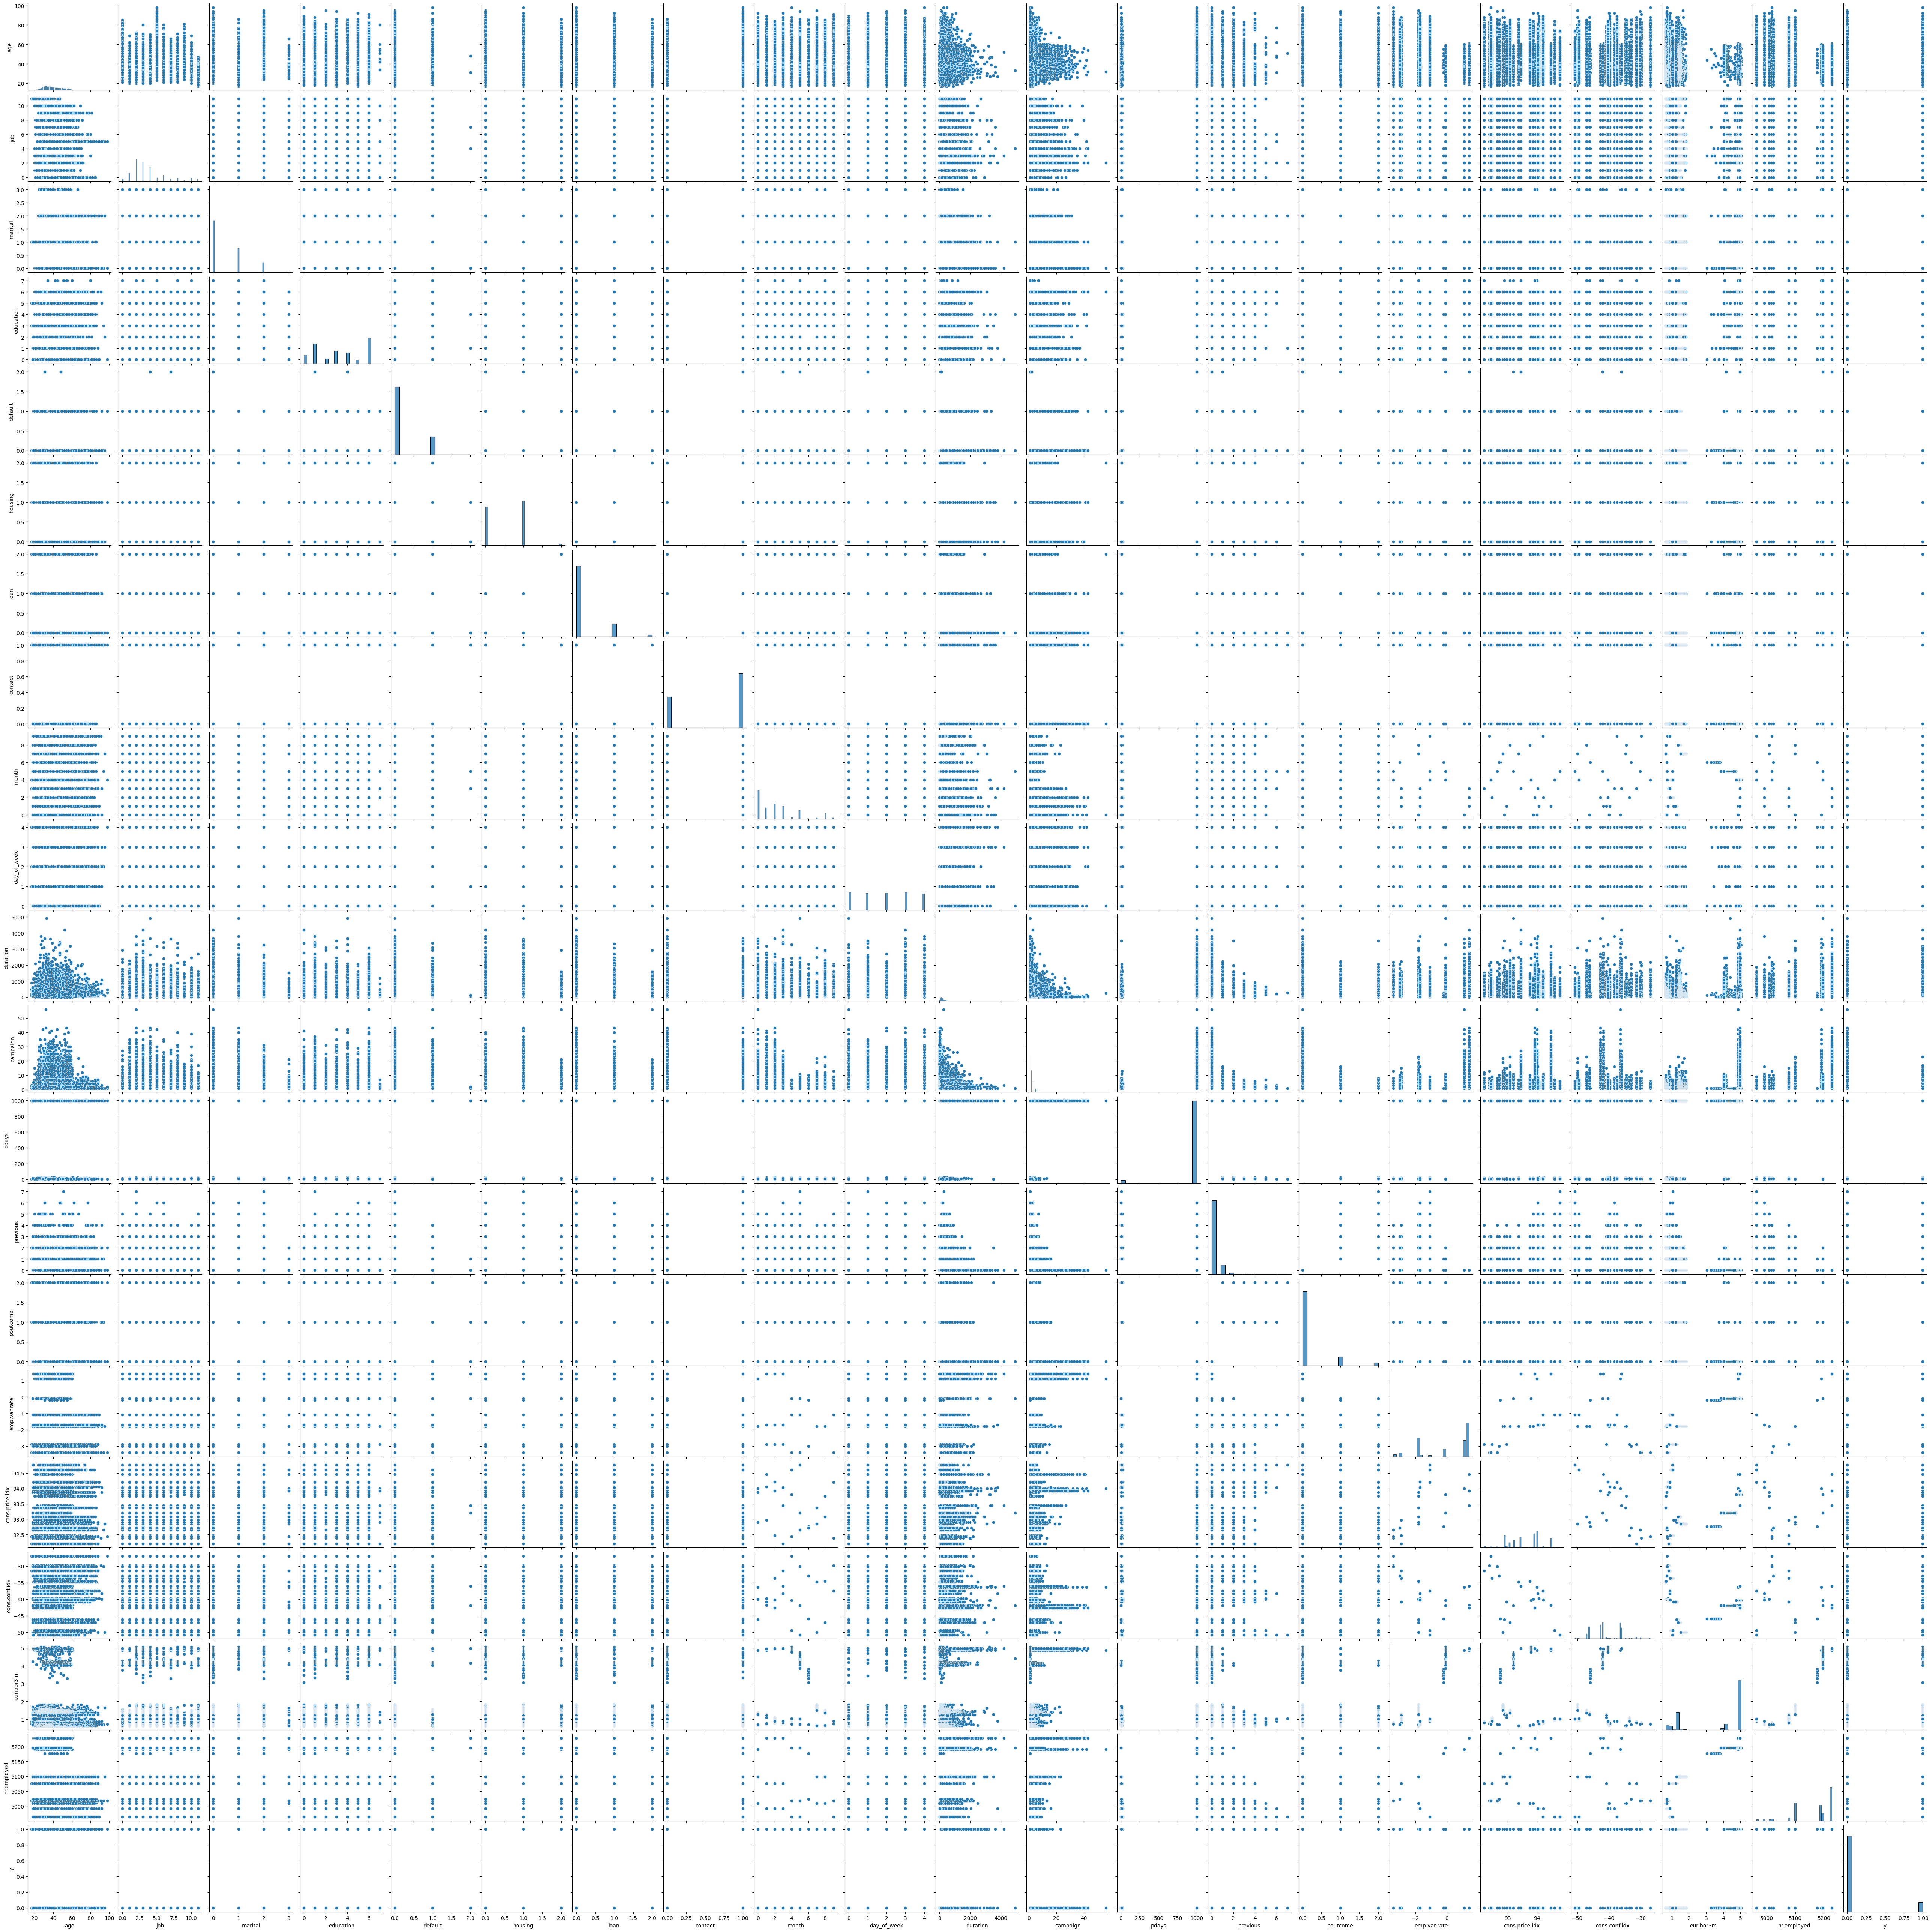

In [26]:
sns.pairplot(data=df_enc)
plt.savefig("Num_cat_corr.png")
plt.show()

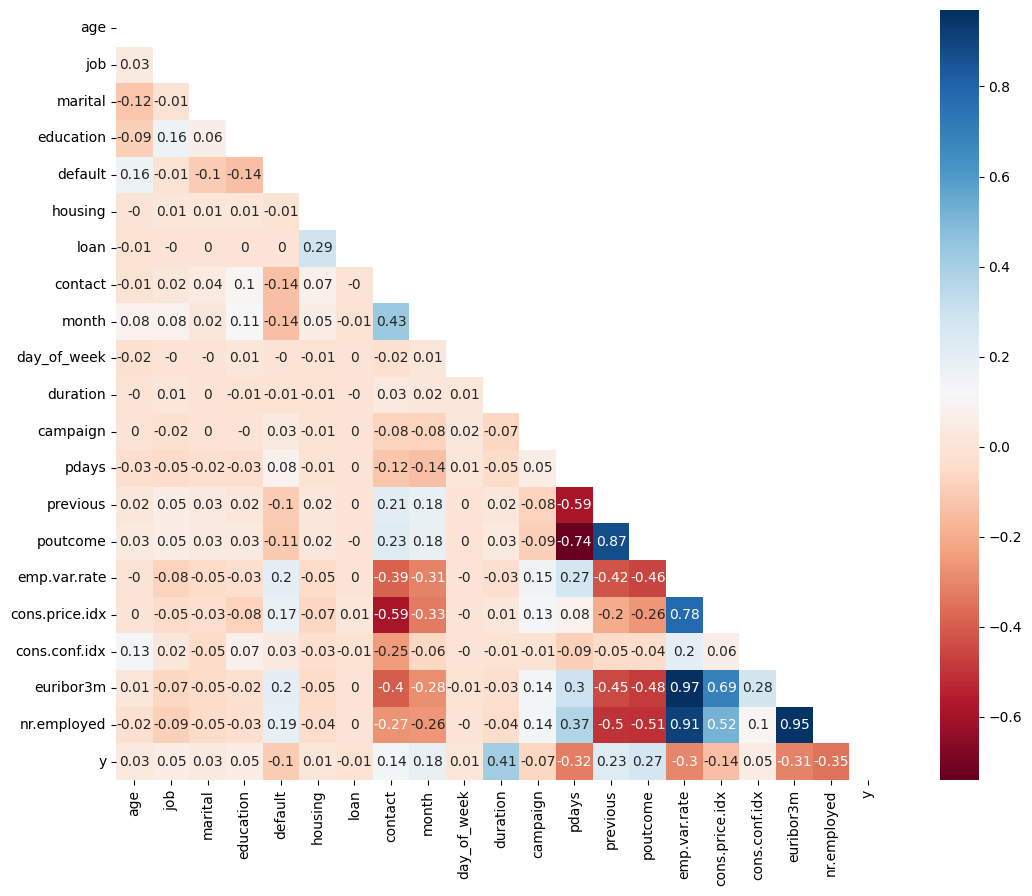

In [27]:
plt.figure(figsize=(14,10))
sns.heatmap(data=df_enc.corr().round(2), annot=True, square= True, cmap="RdBu", mask=np.triu(df_enc.corr()))
plt.savefig("heat_map_corr.png")
plt.show()

***Conclusions:***

**1. `age`**  
- Weak correlations with most variables.  
- Slight negative correlation with `default` (-0.16).  

**2. `marital`**  
- Weak positive correlation with `education` (0.16).  
- Weak negative correlation with `default` (-0.10).

**3. `education`**  
- Moderate positive correlation with `marital` (0.16).  
- Weak negative correlation with `default` (-0.14).

**4. `default`**  
- Negatively correlated with `housing` (-0.10) and `loan` (-0.14).  
- Weak correlations overall.

**5. `loan`**  
- Weak positive correlation with `default` (0.29).  

**6. `month`**  
- Moderate positive correlation with `duration` (0.43).  

**7. `campaign`**  
- Negatively correlated with `poutcome` (-0.74) and `previous` (-0.59).  

**8. `pdays`**  
- Strong negative correlation with `poutcome` (-0.74).  

**9. `previous`**  
- Positively correlated with `poutcome` (0.87).  

**10. `emp.var.rate`**  
- Positively correlated with `cons.price.idx` (0.78).  
- Negatively correlated with `cons.conf.idx` (-0.39).

**11. `cons.price.idx`**  
- Strong positive correlation with `euribor3m` (0.97).  

**12. `cons.conf.idx`**  
- Negatively correlated with `emp.var.rate` (-0.39).  

**13. `euribor3m`**  
- Strong positive correlation with `cons.price.idx` (0.97).  

**14. `nr.employed`**  
- Positively correlated with `euribor3m` (0.95) and `cons.price.idx` (0.91).  

**15. `y` (Target Variable)**  
- Negatively correlated with `emp.var.rate` (-0.31), `nr.employed` (-0.35), and `euribor3m` (-0.34).  
- Positively correlated with `poutcome` (0.27) and `previous` (0.23).  

---

## 3. Feature Engineering

### 3.1 New feature inference

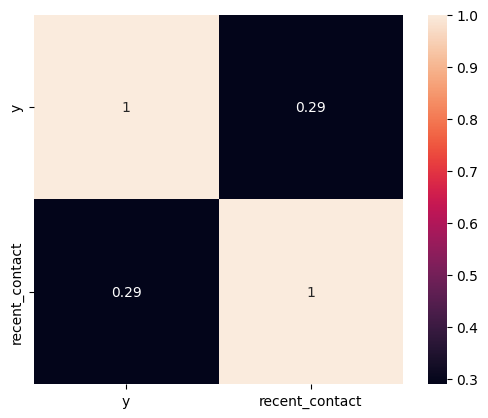

In [28]:
df_enc["recent_contact"] = (df_enc["pdays"] < 999) * df_enc["previous"]

contact_f = df_enc[["y","recent_contact"]]
sns.heatmap(data=contact_f.corr().round(2), annot=True, square=True)
plt.show()

**Conclusion:**

If the customer was contacted recently (pdays < 999), the new recent_contact variable will reflect the number of previous contacts. If the customer was not contacted, the value will be 0.

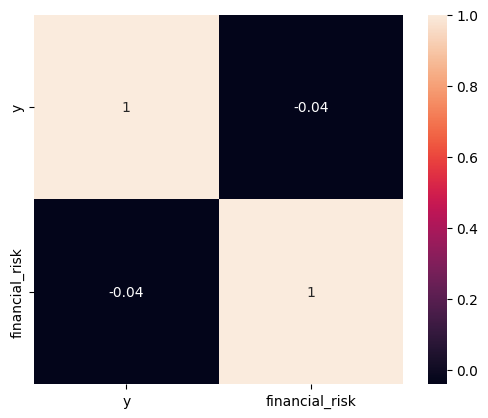

In [29]:
df_enc["financial_risk"] = df_enc[["loan", "housing", "default"]].sum(axis=1)

financial_risk_f = df_enc[["y", "financial_risk"]]
sns.heatmap(data=financial_risk_f.corr().round(2), annot=True, square=True)
plt.show()

**Conclusion:**
We combine these variables to create a financial indicator that reflects the client's financial risk.

financial_risk will have a value between 0 and 3:
- 0: Low risk (no loans or default history).
- 3: High risk (has both types of loans and has defaulted).

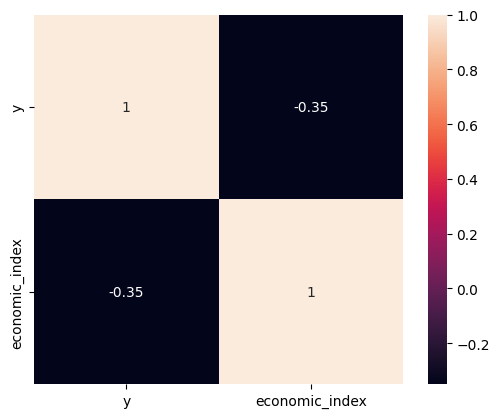

In [30]:
df_enc['economic_index'] = 0.5 * df_enc['cons.price.idx'] + 0.3 * df_enc['euribor3m'] + 0.2 * df_enc['nr.employed']

economic_index_f = df_enc[["y","economic_index"]]
sns.heatmap(data=economic_index_f.corr().round(2), annot=True, square=True)
plt.show()

**Conclusions:**

These variables have a strong correlation with each other and reflect the macroeconomic context. We created a combined feature as an economic index.

The economic_index will represent macroeconomic conditions in a single variable, combining prices, interest rates and employment.

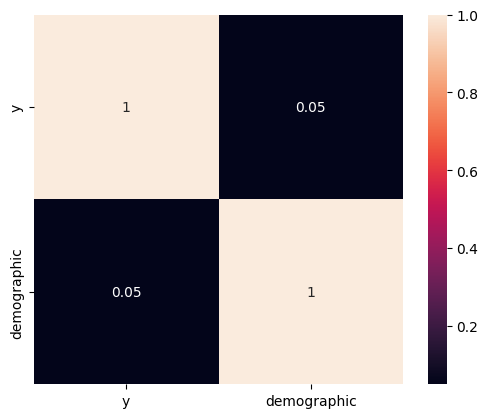

In [31]:
df_enc["demographic"] = df_enc[['age', 'job', 'marital', 'education']].sum(axis=1)

demografic_f = df_enc[["y", "demographic"]]
sns.heatmap(data=demografic_f.corr().round(2), annot=True, square=True)
plt.show()

**Conclusions:**

We combine occupation, educational level, marital status, age to capture the client's socioeconomic status.

### 3.2. Outlier Analysis

Perform an outlier analysis exclusively on continuous features; outliers in discrete features should be addressed separately without changing their data.

In [32]:
df_enc.describe().round(2)

,age,job,marital,education,default,housing,loan,contact,month,day_of_week,...,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed,y,recent_contact,financial_risk,economic_index,demographic
count,41176.00,41176.00,41176.00,41176.00,41176.00,41176.00,41176.00,41176.00,41176.00,41176.00,...,41176.00,41176.00,41176.00,41176.00,41176.00,41176.00,41176.00,41176.00,41176.00,41176.00
mean,40.02,3.67,0.51,3.28,0.21,0.57,0.20,0.63,2.25,1.98,...,0.08,93.58,-40.50,3.62,5167.03,0.11,0.06,0.98,1081.28,47.49
std,10.42,2.45,0.70,2.19,0.41,0.54,0.46,0.48,2.43,1.41,...,1.57,0.58,4.63,1.73,72.25,0.32,0.36,0.90,15.10,10.84
min,17.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,...,-3.40,92.20,-50.80,0.63,4963.60,0.00,0.00,0.00,1040.08,23.00
25%,32.00,2.00,0.00,1.00,0.00,0.00,0.00,0.00,0.00,1.00,...,-1.80,93.08,-42.70,1.34,5099.10,0.00,0.00,0.00,1066.67,40.00
50%,38.00,3.00,0.00,3.00,0.00,1.00,0.00,1.00,2.00,2.00,...,1.10,93.75,-41.80,4.86,5191.00,0.00,0.00,1.00,1086.66,46.00
75%,47.00,4.00,1.00,6.00,0.00,1.00,0.00,1.00,3.00,3.00,...,1.40,93.99,-36.40,4.96,5228.10,0.00,0.00,1.00,1094.07,54.00
max,98.00,11.00,3.00,7.00,2.00,2.00,2.00,1.00,9.00,4.00,...,1.40,94.77,-26.90,5.04,5228.10,1.00,7.00,5.00,1094.34,104.00


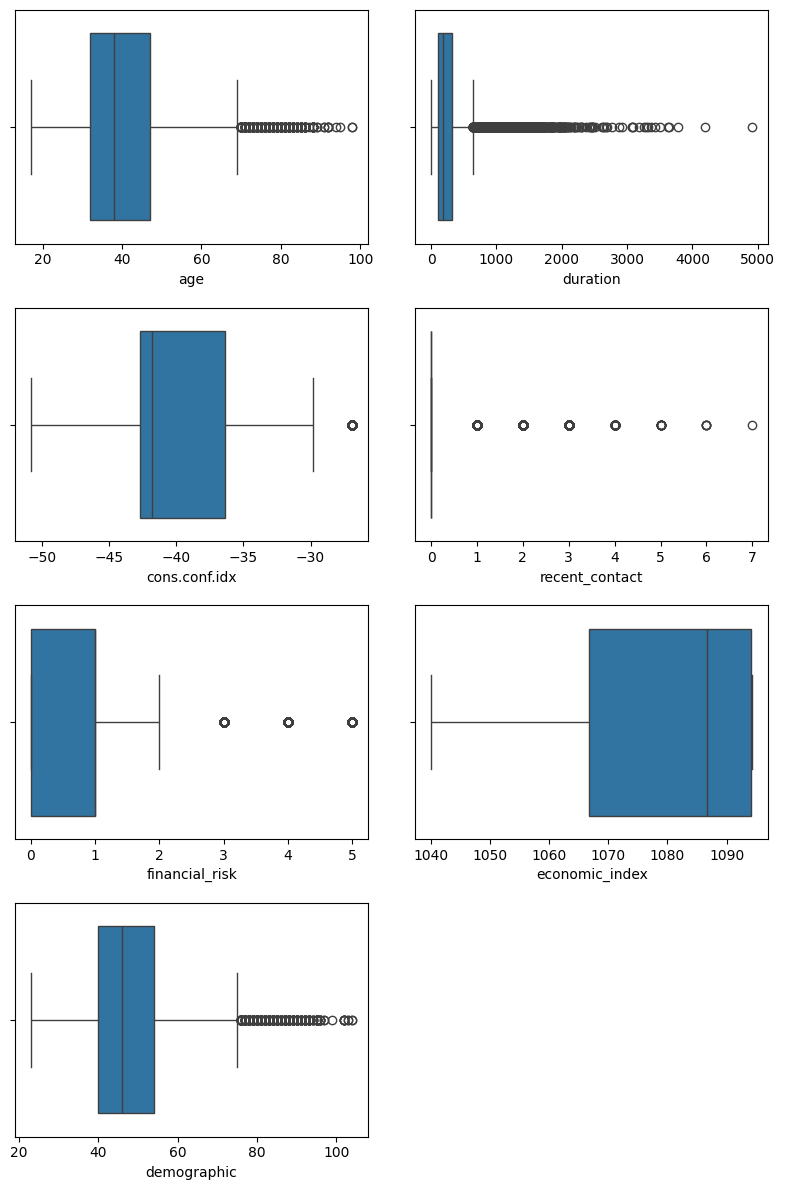

In [33]:
fig, ax = plt.subplots(4,2,figsize=(8,12))

sns.boxplot(ax = ax[0,0], data=df_enc, x="age")
sns.boxplot(ax = ax[0,1], data=df_enc, x="duration")
sns.boxplot(ax = ax[1,0], data=df_enc, x="cons.conf.idx")
sns.boxplot(ax = ax[1,1], data=df_enc, x="recent_contact")
sns.boxplot(ax = ax[2,0], data=df_enc, x="financial_risk")
sns.boxplot(ax = ax[2,1], data=df_enc, x="economic_index")
sns.boxplot(ax = ax[3,0], data=df_enc, x="demographic")

plt.tight_layout()
fig.delaxes(ax[3,1])
plt.show()

We will calculate the outlier limits for duration, contacts, and cons.conf.idx. This data will be used to create a new data frame without outliers (df_enc_no), which we will use to train our model and compare performance to determine the best approach.

In [34]:
df_enc_no = df_enc.copy()

In [35]:
def remove_outliers(x, feature_name, allow_neg=True):
    q1, q3 = x.quantile([0.25, 0.75])
    iqr = q3 - q1
    upper_lim = q3 + (iqr*1.5)
    lower_lim = q1 - (iqr*1.5) if allow_neg else max(0, q1 - (iqr * 1.5))

    x = x.apply(lambda x: upper_lim if (x > upper_lim) else (lower_lim if (x < lower_lim) else x))

    filename = f'../data/interim/outliers_lims_{feature_name}.json'
    json.dump({'upper_lim': upper_lim, 'lower_lim': lower_lim}, open(filename, 'w'))

    return x

In [36]:
f_outliers_no_neg = ['duration', 'recent_contact','demographic', 'financial_risk']
f_outliers_with_neg = ['cons.conf.idx']

In [37]:
for feature in f_outliers_no_neg:
    df_enc_no[feature] = remove_outliers(df_enc_no[feature], feature, allow_neg=False)

for feature in f_outliers_with_neg:
    df_enc_no[feature] = remove_outliers(df_enc_no[feature], feature)

In [38]:
df_enc_no.head()

,age,job,marital,education,default,housing,loan,contact,month,day_of_week,...,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed,y,recent_contact,financial_risk,economic_index,demographic
0,56,0,0,0,0,0,0,0,0,0,...,1.1,93.994,-36.4,4.857,5191.0,0,0.0,0.0,1086.6541,56.0
1,57,1,0,1,1,0,0,0,0,0,...,1.1,93.994,-36.4,4.857,5191.0,0,0.0,1.0,1086.6541,59.0
2,37,1,0,1,0,1,0,0,0,0,...,1.1,93.994,-36.4,4.857,5191.0,0,0.0,1.0,1086.6541,39.0
3,40,2,0,2,0,0,0,0,0,0,...,1.1,93.994,-36.4,4.857,5191.0,0,0.0,0.0,1086.6541,44.0
4,56,1,0,1,0,0,1,0,0,0,...,1.1,93.994,-36.4,4.857,5191.0,0,0.0,1.0,1086.6541,58.0


### 3.3 Missing Values

In [39]:
df_enc.isna().sum()[df_enc.isna().sum() > 0]

Series([], dtype: int64)

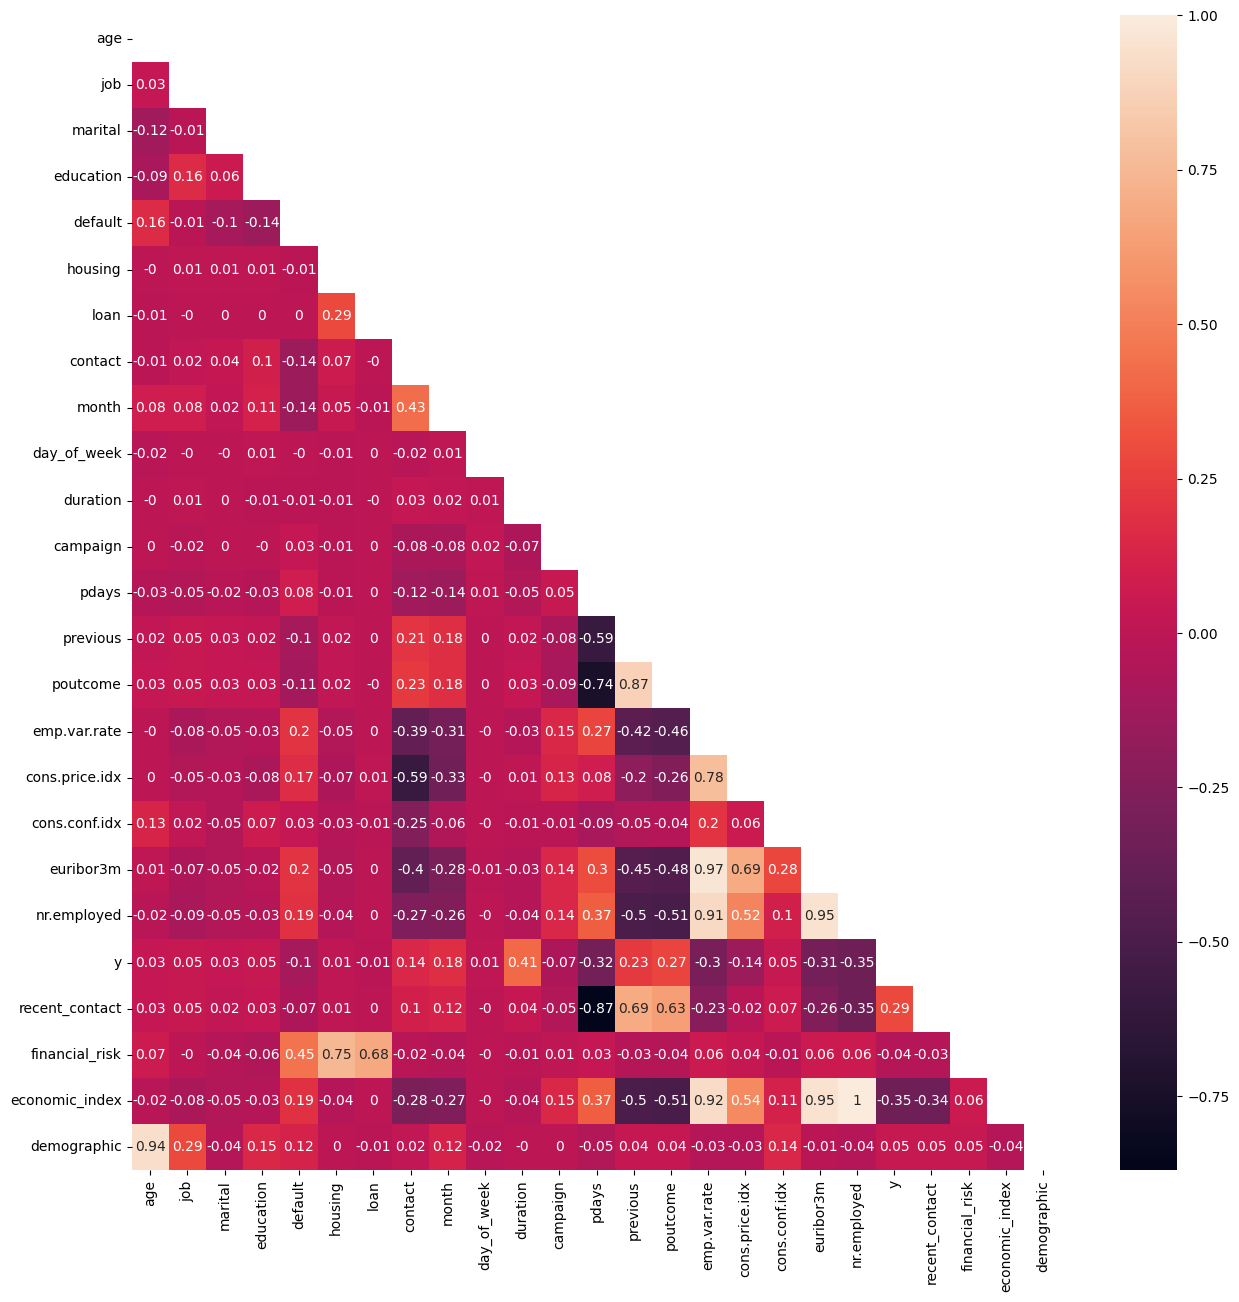

In [40]:
plt.figure(figsize=(15,15))
sns.heatmap(df_enc.corr().round(2), annot=True, mask=np.triu(df_enc.corr()))
plt.show()

---

## 4. Split train/test of both Dataframes

In [41]:
def split(target, df, test_size=0.2, random_state=123):
    X = df.drop(columns=target)
    y = df[target]

    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, random_state=random_state)
    return X_train, X_test, y_train, y_test

In [42]:
X_train_with_outliers, X_test_with_outliers, y_train, y_test = split(target="y", df=df_enc)
X_train_without_outliers, X_test_without_outliers, _, _ = split(target="y", df=df_enc_no)

X_train_with_outliers.to_csv('../data/processed/X_train_with_outliers.csv', index=False)
X_test_with_outliers.to_csv('../data/processed/X_test_with_outliers.csv', index=False)
X_train_without_outliers.to_csv('../data/processed/X_train_without_outliers.csv', index=False)
X_test_without_outliers.to_csv('../data/processed/X_test_without_outliers.csv', index=False)

y_train.to_csv('../data/processed/y_train.csv', index=False)
y_test.to_csv('../data/processed/y_test.csv', index=False)

---

## 5. Normalization

In [43]:
def norm(X_train, X_test, reference: str):
    scaler = StandardScaler()
    scaler.fit(X_train)
    
    X_train_norm = scaler.transform(X_train)
    X_train_norm = pd.DataFrame(X_train_norm, index=X_train.index, columns=X_train.columns)

    X_test_norm = scaler.transform(X_test)
    X_test_norm = pd.DataFrame(X_test_norm, index=X_test.index, columns=X_test.columns)

    dump(scaler, open(f'../data/processed/normalized_{reference}.sav', 'wb'))

    return X_train_norm, X_test_norm

In [44]:
X_train_with_outliers_norm, X_test_with_outliers_norm = norm(X_train_with_outliers, X_test_with_outliers, 'with_outliers')
X_train_without_outliers_norm, X_test_without_outliers_norm = norm(X_train_without_outliers, X_test_without_outliers, 'without_outliers')

## 6. Min-Max Scaling

In [45]:
def minmax(X_train, X_test, reference: str):
    scaler = MinMaxScaler()
    scaler.fit(X_train)
    
    X_train_minmax = scaler.transform(X_train)
    X_train_minmax = pd.DataFrame(X_train_minmax, index = X_train.index, columns=X_train.columns)

    X_test_minmax = scaler.transform(X_test)
    X_test_minmax = pd.DataFrame(X_test_minmax, index = X_test.index, columns=X_test.columns)
    
    dump(scaler, open(f'../data/processed/minmax_{reference}.sav', 'wb'))

    return X_train_minmax, X_test_minmax

In [46]:
X_train_with_outliers_minmax, X_test_with_outliers_minmax = minmax(X_train_with_outliers, X_test_with_outliers, 'with_outliers')
X_train_without_outliers_minmax, X_test_without_outliers_minmax = minmax(X_train_without_outliers, X_test_without_outliers, 'without_outliers')

---

## 7. Feature Selection

In [47]:
def kselection(X_train, X_test, y_train, k, reference: str):
    selection_model = SelectKBest(f_classif, k=k)
    selection_model.fit(X_train, y_train)
    cols = selection_model.get_support()

    X_train_sel = pd.DataFrame(selection_model.transform(X_train), columns=X_train.columns.values[cols]) 
    X_test_sel = pd.DataFrame(selection_model.transform(X_test), columns=X_test.columns.values[cols])

    dump(selection_model, open(f'../data/processed/selection_model_{reference}.sav', 'wb'))

    return X_train_sel, X_test_sel

In [48]:
X_train_with_outliers_sel, X_test_with_outliers_sel = kselection(X_train_with_outliers, X_test_with_outliers, y_train, 11, 'with_outliers')
X_train_without_outliers_sel, X_test_without_outliers_sel = kselection(X_train_without_outliers, X_test_without_outliers, y_train, 11, 'without_outliers')

/workspace/.pyenv_mirror/user/current/lib/python3.12/site-packages/sklearn/feature_selection/_univariate_selection.py:113: RuntimeWarning: invalid value encountered in divide
  f = msb / msw


In [49]:
X_train_with_outliers_sel.head(3)

,contact,month,duration,pdays,previous,poutcome,emp.var.rate,euribor3m,nr.employed,recent_contact,economic_index
0,1.0,2.0,733.0,999.0,0.0,0.0,1.4,4.962,5228.1,0.0,1094.0676
1,1.0,5.0,407.0,999.0,0.0,0.0,-0.1,4.191,5195.8,0.0,1087.0173
2,1.0,0.0,113.0,999.0,2.0,1.0,-1.8,0.682,5008.7,0.0,1048.8826


### 7.1 Applying the columns filter (kselection) to the normalized and minmax scaled data frames

In [50]:
X_train_with_outliers_norm_sel = X_train_with_outliers_norm[X_train_with_outliers_sel.columns]
X_train_without_outliers_norm_sel = X_train_without_outliers_norm[X_train_with_outliers_sel.columns]

X_test_with_outliers_norm_sel = X_test_with_outliers_norm[X_test_with_outliers_sel.columns]
X_test_without_outliers_norm_sel = X_test_without_outliers_norm[X_test_with_outliers_sel.columns]

X_train_with_outliers_minmax_sel = X_train_with_outliers_minmax[X_train_with_outliers_sel.columns]
X_train_without_outliers_minmax_sel = X_train_without_outliers_minmax[X_train_without_outliers_sel.columns]

X_test_with_outliers_minmax_sel = X_test_with_outliers_minmax[X_test_with_outliers_sel.columns]
X_test_without_outliers_minmax_sel = X_test_without_outliers_minmax[X_test_without_outliers_sel.columns]

### 7.2 Saving the CSV files

In [51]:
dfs_train = {
    'X_train_with_outliers_sel': X_train_with_outliers_sel,
    'X_train_without_outliers_sel': X_train_without_outliers_sel,
    'X_train_with_outliers_norm_sel': X_train_with_outliers_norm_sel,
    'X_train_without_outliers_norm_sel': X_train_without_outliers_norm_sel,
    'X_train_with_outliers_minmax_sel': X_train_with_outliers_minmax_sel,
    'X_train_without_outliers_minmax_sel': X_train_without_outliers_minmax_sel 
}

dfs_test = {
    'X_test_with_outliers_sel': X_test_with_outliers_sel,
    'X_test_without_outliers_sel': X_test_without_outliers_sel,
    'X_test_with_outliers_norm_sel': X_test_with_outliers_norm_sel,
    'X_test_without_outliers_norm_sel': X_test_without_outliers_norm_sel,
    'X_test_with_outliers_minmax_sel': X_test_with_outliers_minmax_sel,
    'X_test_without_outliers_minmax_sel': X_test_without_outliers_minmax_sel    
}

for name, df in dfs_train.items():
    df.to_csv(f"../data/processed/{name}.csv", index=False)

for name, df in dfs_test.items(): 
    df.to_csv(f'../data/processed/{name}.csv', index=False)

---

## 8. Machine Learning

### 8.1 Logistic regression

In [52]:
train, test = [], []

for name, df in dfs_train.items():
    train.append(df)
for name, df in dfs_test.items():
    test.append(df)

In [54]:
results = []

for index in range(len(train)):
    model = LogisticRegression()
    train_df = train[index]
    model.fit(train_df, y_train)
    y_train_pred = model.predict(train_df)
    y_test_pred = model.predict(test[index])

    results.append(
        {
            "index": index,
            "df_train": list(dfs_train.keys())[index],
            "train_score": accuracy_score(y_train, y_train_pred),
            "test_score": accuracy_score(y_test, y_test_pred),
            'Coef': model.coef_,
            'MAE': mean_absolute_error(y_test, y_test_pred).round(2),
            'RMSE': round(root_mean_squared_error(y_test, y_test_pred),2),
            "R2_score": round(r2_score(y_test, y_test_pred),5)
        }
    )
    

results = sorted(results, key=lambda x: x['train_score'], reverse=True)
best_ind = results[0]["index"]
best_df_train = results[0]["df_train"]
results

[{'index': 2,
  'df_train': 'X_train_with_outliers_norm_sel',
  'train_score': 0.9092592592592592,
  'test_score': 0.9061437591063624,
  'Coef': array([[ 0.26022235,  0.15341317,  1.16477408, -0.25026104, -0.22988166,
           0.03328741, -0.75086857,  0.96255555, -0.65403807,  0.16427458,
          -0.55382464]]),
  'MAE': np.float64(0.09),
  'RMSE': np.float64(0.31),
  'R2_score': 0.07684},
 {'index': 4,
  'df_train': 'X_train_with_outliers_minmax_sel',
  'train_score': 0.9087431693989071,
  'test_score': 0.9059009227780476,
  'Coef': array([[ 0.51563163,  0.56168562, 19.25383142, -2.01613051, -1.18352726,
          -0.41317551, -1.91137183,  2.02746028, -2.13612835,  0.65671904,
          -1.90221158]]),
  'MAE': np.float64(0.09),
  'RMSE': np.float64(0.31),
  'R2_score': 0.07445},
 {'index': 0,
  'df_train': 'X_train_with_outliers_sel',
  'train_score': 0.9078020643594414,
  'test_score': 0.9044439048081593,
  'Coef': array([[ 0.10955173,  0.08710065,  0.00446091, -0.00208296, -0

### 8.2 Hyper parameters

#### 8.2.1 Grid Search

In [55]:
hyperparams = {
    "C": [0.001, 0.01, 0.1, 1, 10, 100, 1000],
    "penalty": ["l1", "l2", "elasticnet", None],
    "solver": ["newton-cg", "lbfgs", "liblinear", "sag", "saga"]
}

model = LogisticRegression()
model.fit(dfs_train.get(best_df_train), y_train)
grid = GridSearchCV(model, hyperparams, scoring = "accuracy", cv = 5)
grid.fit(dfs_train.get(best_df_train), y_train)
print(f'The best hyperparameters are: {grid.best_params_}')

The best hyperparameters are: {'C': 0.001, 'penalty': None, 'solver': 'sag'}


In [57]:
model_grid = LogisticRegression(C=0.001, penalty=None, solver='sag')
model_grid.fit(dfs_train.get(best_df_train), y_train)
y_pred = model_grid.predict(dfs_test.get(list(dfs_test)[best_ind]))
grid_accuracy = accuracy_score(y_test, y_pred)
grid_accuracy

0.9066294317629917

### 8.2.2 Random Search

In [58]:
hyperparams = {
    "C": np.logspace(0.01, 100, 10),
    "penalty": ["l1", "l2", "elasticnet", None],
    "solver": ["newton-cg", "lbfgs", "liblinear", "sag", "saga"]
}

random_search = RandomizedSearchCV(model, hyperparams, n_iter = 100, scoring = "accuracy", cv = 5, random_state = 123)
random_search.fit(dfs_train.get(best_df_train), y_train)
print(f'The best hyperparameters are: {random_search.best_params_}')

The best hyperparameters are: {'solver': 'sag', 'penalty': None, 'C': np.float64(6.025595860743593e+77)}


In [59]:
model_rsearch = LogisticRegression(C=6.025595860743593e+77, penalty=None, solver='sag')
model_rsearch.fit(dfs_train.get(best_df_train), y_train)
y_pred = model_rsearch.predict(dfs_test.get(list(dfs_test)[best_ind]))
rsearch_accuracy = accuracy_score(y_test, y_pred)
rsearch_accuracy

0.9066294317629917